In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pastas as ps
ps.set_log_level("ERROR")

### Kalibratie van een tijdreeksmodel

In algemene zin wordt onder kalibratie verstaan het vinden van de modelparameters zodat de uitkomst van het tijdreeksmodel zo goed mogelijk overeenkomt met de gemeten waarden. De gevonden parameters worden de optimale parameters genoemd. Maar hoe wordt 'zo goed mogelijk' gedefinieerd? De meest gebruikte methode is de minimalisatie van de de som van de kwadraten van de verschillen tussen de gemeten stijghoogte en de gemodelleerde stijghoogte (de residuën), ook wel de kleinste kwadraten methode genoemd. De som van de kwadraten is een niet-lineaire functie van de modelparameters. Om de optimale modelparameters te vinden wordt gebruikt gemaakt van een zoekmethode. 

Er bestaan een aantal verschillende zoekmethoden die gebruikt kunnen worden om de optimale modelparameters te vinden. Iedere zoekmethode is gebaseerd op een ander zoek algoritme, maar het idee is altijd hetzelfde: het model wordt een aantal keer gedraaid met verschillende waarden van de modelparameters. Gebaseerd op de verschillende modeluitkomsten (en de daaruit voorvloeiende som van de kwadraten) bepaald het zoekalgoritme een volgende mogelijke set modelparameters die hopelijk een kleinere som van de kwadraten oplevert. Het zoekalgoritme gaat door totdat het besluit dat het de beste parameters gevonden heeft. De efficientie van het zoekalgoritme wordt bepaald door het aantal model runs dat nodig is om de optimale modelparameters te vinden. Het is vanzelfsprekend aan te bevelen om de initiele modelparameters zo dicht mogelijk bij de optimale modelparameters te kiezen. Daartoe heeft de meeste software geprobeerd om slimme keuzes te maken voor de waarden van de modelparameters waar het zoek algoritme mee begint (de initiele waarden), maar soms kan het handig zijn om de initiele waarden handmatig aan te passen. De kans op succes van het zoekalgoritme hangt af van het zoekalgoritme zelf, de ingewikkeldheid van het model en, wederom, de waarden van de initiele parameters. Om met het laatste te beginnen: wederom geldt dat de kans op succes groter is als het zoekalgoritme dichter bij de optimale parameters begint. Daarnaast speelt de slimheid van het zoekalgoritme een rol. Sommige zoekalgoritmes zoeken de optimale modelparameters door de modelparameters steeds een beetje aan te passen zodat de som van de kwadraten kleiner wordt. Dit kan tot gevolg hebben dat het zoekalgoritme in een lokaal minimum belandt. Andere zoekalgoritmes gaan ook zoeken 



Er wordt vanuit gegaan dat er een modelstructuur gekozen is (zie Notebook Modelstructuur). Daarnaast dienen er nog een aantal andere keuzes gemaakt te worden:
1. Wanneer begint het model en worden alle data gebruikt om het model te kalibreren?
2. Wat is optimaal? De meest gebruikte methode is minimalisatie van de de som van de kwadraten van de verschillen tussen de gemeten stijghoogte en de gemodelleerde stijghoogte, ook wel de kleinste kwadraten methode genoemd.
3. Welke methode wordt gebruikt voor het vinden van de optimale parameters? Er zijn vele verschillende methodes voor het zoeken van optimale parameters met verschillende kenmerken. Het succes van de meeste methodes hangt af van de opgegeven beginwaarden van de parameters. 
4. 

Het mogelijke gevolg van iedere keuze wordt toegelicht aan de hand van geslaagde en minder geslaagde voorbeeldmodellen uit de praktijk.


### Hoe lang moet een stijghoogte reeks zijn om een tijdreeksmodel te kunnen maken?


### Moet er een ruismodel gebruikt worden?
Wordt er een ruismodel gebruikt of niet, en als er een ruismodel gebruikt wordt, welk ruismodel? Een ruismodel kan gebruikt worden om te proberen er voor te zorgen dat de overgebleven verschillen tussen het model en de metingen aan een aantal statistische toetsen voldoen zodat er statistische uitspraken gedaan kunnen worden met het model (bijvoorbeeld: wat is de kans dat het effect van een onttrekking boven een bepaalde grenswaarde uitkomt).

### Optimale parameters

In [12]:
ho = pd.read_csv('data/head_nb1.csv', parse_dates=['date'], index_col='date', squeeze=True)
rain = pd.read_csv('data/rain_nb1.csv', parse_dates=['date'], index_col='date', squeeze=True)
evap = pd.read_csv('data/evap_nb1.csv', parse_dates=['date'], index_col='date', squeeze=True)

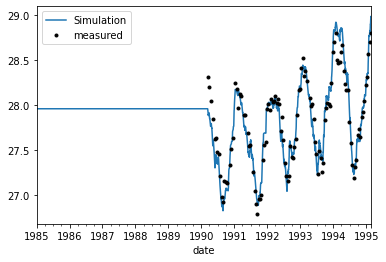

In [13]:
# start at peak
start = ho['1990'].idxmax()
end = ho['1995'].idxmax()
#ml = ps.Model(ho[start:end])
ml = ps.Model(ho)
rm = ps.RechargeModel(rain[start:], evap[start:], ps.Gamma, name='recharge')
ml.add_stressmodel(rm)
ml.solve(tmin=start, tmax=end, report=False)
h = ml.simulate(tmin='1985', tmax=end)
ax = h.plot()
ho[start:end].plot(style='.', color='k', ax=ax, label='measured')
plt.legend();

In [16]:
ml.residuals().mean()

-0.014218094358464512

In [3]:
h = ml.simulate(tmin='1985', tmax='2001')
ax = h.plot()
ho[start:'2000'].plot(style='.', color='k', ax=ax, label='measured')
plt.legend()

NameError: name 'ml' is not defined

p value: 0.6865215531185356


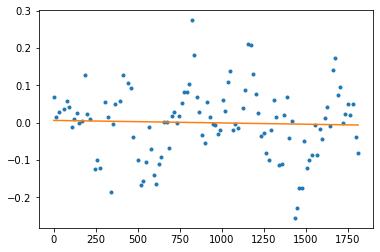

In [162]:
from scipy.stats import linregress
time = (ho[start:end].index - start).days
res = ml.residuals()
plt.plot(time, res, '.')
slope, intercept, r, p, se = linregress(time, res)
print('p value:', p)
plt.plot(time, slope * time + intercept)

INFO: Cannot determine frequency of series head: freq=None. The time series is irregular.
INFO: Inferred frequency for time series rain: freq=D
INFO: Inferred frequency for time series evap: freq=D
INFO: Time Series rain was extended to 1980-01-17 00:00:00 with the mean value of the time series.
INFO: Time Series evap was extended to 1980-01-17 00:00:00 with the mean value of the time series.
INFO: Time Series rain was extended to 1975-01-04 00:00:00 with the mean value of the time series.
INFO: Time Series evap was extended to 1975-01-04 00:00:00 with the mean value of the time series.


Fit report head                  Fit Statistics
nfev     19                     EVP          95.68
nobs     112                    R2            0.96
noise    True                   RMSE          0.10
tmin     1990-01-14 00:00:00    AIC          11.94
tmax     1995-01-01 00:00:00    BIC          28.25
freq     D                      Obj           0.26
warmup   3650 days 00:00:00     ___               
solver   LeastSquares           Interpolated    No

Parameters (6 were optimized)
                optimal   stderr     initial  vary
recharge_A   717.763694   ±4.51%  213.263634  True
recharge_n     1.055707   ±1.72%    1.000000  True
recharge_a   144.673672   ±6.23%   10.000000  True
recharge_f    -1.221691   ±4.72%   -1.000000  True
constant_d    27.841778   ±0.24%   27.884645  True
noise_alpha   43.863782  ±12.71%   15.000000  True

Parameter correlations |rho| > 0.5
recharge_A recharge_a  0.54
recharge_n recharge_a -0.80
           recharge_f  0.56
           constant_d -0.56
recharge

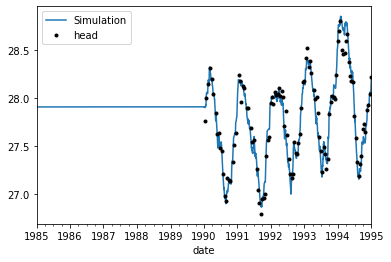

In [33]:
from scipy.stats import linregress
time = (ho[start:end].index - start).days
res = ml1.residuals()
plt.plot(time, res, '.')
slope, intercept, r, p, se = linregress(time, res)
print('p value:', p)
plt.plot(time, slope * time + intercept)

INFO: Cannot determine frequency of series head: freq=None. The time series is irregular.
INFO: Inferred frequency for time series rain: freq=D
INFO: Inferred frequency for time series evap: freq=D
INFO: Time Series rain was extended to 1975-01-04 00:00:00 with the mean value of the time series.
INFO: Time Series evap was extended to 1975-01-04 00:00:00 with the mean value of the time series.


Fit report head                  Fit Statistics
nfev     18                     EVP          95.62
nobs     112                    R2            0.96
noise    True                   RMSE          0.10
tmin     1990-01-14 00:00:00    AIC          11.94
tmax     1995-01-01 00:00:00    BIC          28.25
freq     D                      Obj           0.26
warmup   3650 days 00:00:00     ___               
solver   LeastSquares           Interpolated    No

Parameters (6 were optimized)
                optimal   stderr     initial  vary
recharge_A   729.590379   ±4.34%  215.674528  True
recharge_n     1.057558   ±1.71%    1.000000  True
recharge_a   146.063774   ±6.25%   10.000000  True
recharge_f    -1.212953   ±4.61%   -1.000000  True
constant_d    27.836516   ±0.23%   27.884645  True
noise_alpha   43.947230  ±12.67%   15.000000  True

Parameter correlations |rho| > 0.5
recharge_A recharge_a  0.54
recharge_n recharge_a -0.81
           recharge_f  0.57
           constant_d -0.58
recharge

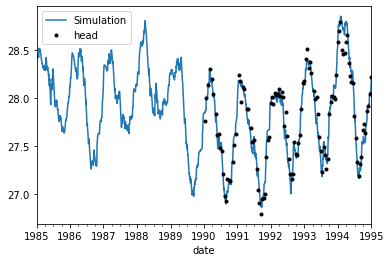

In [34]:
ml1990 = ps.Model(ho1990)
rm = ps.RechargeModel(rain, evap, ps.Gamma, name='recharge')
ml1990.add_stressmodel(rm)
ml1990.solve(tmax='1-1-1995')
h = ml1990.simulate(tmin='1-1-1985', tmax='1-1-1995')
ax = h.plot()
ho['1990':'1994'].plot(style='.', color='k', ax=ax, label='measured')
plt.legend()

INFO: Cannot determine frequency of series head: freq=None. The time series is irregular.
INFO: Inferred frequency for time series rain: freq=D
INFO: Inferred frequency for time series evap: freq=D
INFO: Time Series rain was extended to 1975-11-17 00:00:00 with the mean value of the time series.
INFO: Time Series evap was extended to 1975-11-17 00:00:00 with the mean value of the time series.
INFO: Time Series rain was extended to 1970-01-03 00:00:00 with the mean value of the time series.
INFO: Time Series evap was extended to 1970-01-03 00:00:00 with the mean value of the time series.


Fit report head                  Fit Statistics
nfev     18                     EVP          92.86
nobs     644                    R2            0.93
noise    True                   RMSE          0.11
tmin     1985-11-14 00:00:00    AIC           7.70
tmax     2015-06-28 00:00:00    BIC          34.51
freq     D                      Obj           2.02
warmup   3650 days 00:00:00     ___               
solver   LeastSquares           Interpolated    No

Parameters (6 were optimized)
                optimal   stderr     initial  vary
recharge_A   683.251981   ±5.31%  216.483464  True
recharge_n     1.017237   ±1.79%    1.000000  True
recharge_a   150.948545   ±7.58%   10.000000  True
recharge_f    -1.270004   ±4.82%   -1.000000  True
constant_d    27.878206   ±0.25%   27.900078  True
noise_alpha   50.987426  ±11.96%   15.000000  True

Parameter correlations |rho| > 0.5
recharge_A recharge_a  0.62
recharge_n recharge_a -0.77
           recharge_f  0.53
           constant_d -0.52
recharge

<AxesSubplot:>

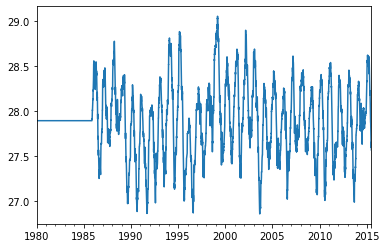

In [14]:
ml = ps.Model(ho)
rm = ps.RechargeModel(rain1985, evap1985, ps.Gamma, name='recharge')
ml.add_stressmodel(rm)
ml.solve()
h = ml.simulate(tmin='1-1-1980')
h.plot()

INFO: Cannot determine frequency of series head: freq=None. The time series is irregular.
INFO: Inferred frequency for time series rain: freq=D
INFO: Inferred frequency for time series evap: freq=D
INFO: Time Series rain was extended to 1975-11-17 00:00:00 with the mean value of the time series.
INFO: Time Series evap was extended to 1975-11-17 00:00:00 with the mean value of the time series.


Fit report head                Fit Statistics
nfev     13                     EVP          93.29
nobs     644                    R2           0.93
noise    False                  RMSE         0.11
tmin     1985-11-14 00:00:00    AIC          nan
tmax     2015-06-28 00:00:00    BIC          nan
freq     D                      Obj          4.00
warmup   3650 days 00:00:00     ___             
solver   LeastSquares           Interpolated  No

Parameters (5 were optimized)
               optimal  stderr     initial  vary
recharge_A  618.950773  ±2.79%  215.674528  True
recharge_n    1.049266  ±2.07%    1.000000  True
recharge_a  146.190448  ±5.92%   10.000000  True
recharge_f   -1.408103  ±3.17%   -1.000000  True
constant_d   28.019644  ±0.16%   27.900078  True

Parameter correlations |rho| > 0.5
recharge_A recharge_a  0.54
recharge_n recharge_a -0.91
           recharge_f  0.56
           constant_d -0.60
recharge_a recharge_f -0.59
           constant_d  0.64
recharge_f constant_d -0.99


[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:title={'left':'Model Parameters'}>,
 <AxesSubplot:title={'right':"Stresses: ['rain', 'evap']"}>,
 <AxesSubplot:xlabel='Time [days]'>]

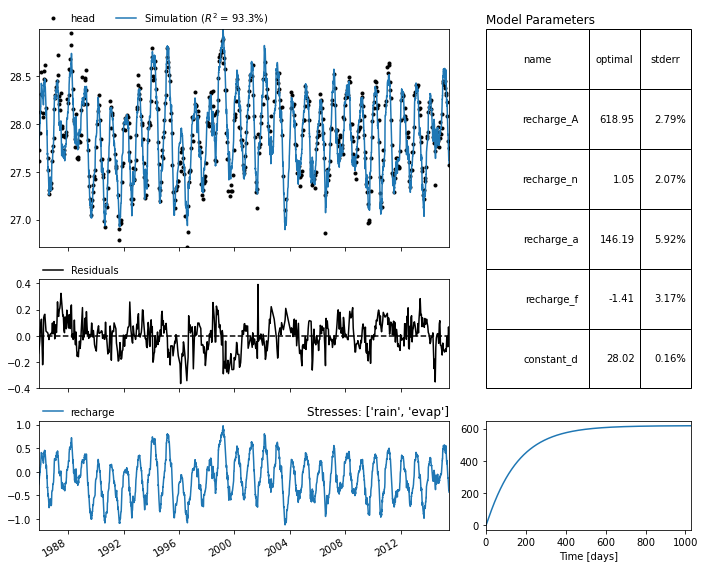

In [11]:
ml = ps.Model(ho, noisemodel=True)
rm = ps.RechargeModel(rain, evap, ps.Gamma, name='recharge')
ml.add_stressmodel(rm)
ml.solve(noise=False)
ml.plots.results()

In [41]:
ml.set_parameter??

Signature:
ml.set_parameter(
    name,
    initial=None,
    vary=None,
    pmin=None,
    pmax=None,
    move_bounds=False,
)
Source:   
    def set_parameter(self, name, initial=None, vary=None, pmin=None,
                      pmax=None, move_bounds=False):
        """Method to change the parameter properties.

        Parameters
        ----------
        name: str
            name of the parameter to update. This has to be a single variable.
        initial: float, optional
            parameters value to use as initial estimate.
        vary: bool, optional
            boolean to vary a parameter (True) or not (False).
        pmin: float, optional
            minimum value for the parameter.
        pmax: float, optional
            maximum value for the parameter.
        move_bounds: bool, optional
            Reset pmin/pmax based on new initial value. Of move_bounds=True,
            pmin and pmax must be None.

        Examples
        --------
        >>> ml.set_parameter(

In [39]:
ml.set_parameter('recharge_A', initial=200)

In [40]:
ml.parameters

,initial,name,optimal,pmin,pmax,vary,stderr
recharge_A,200.000000,recharge,700.000000,0.00001,21567.452806,True,17.271134
recharge_n,1.000000,recharge,1.049266,0.10000,100.000000,True,0.021706
recharge_a,10.000000,recharge,146.190448,0.01000,10000.000000,True,8.656525
recharge_f,-1.000000,recharge,-1.408103,-2.00000,0.000000,True,0.044598
constant_d,27.900078,constant,28.019644,NaN,NaN,True,0.043846


In [30]:
ml.parameters.loc['recharge_A', 'optimal']

618.9507730777667

Fit report head                Fit Statistics
nfev     13                     EVP          93.29
nobs     644                    R2           0.93
noise    False                  RMSE         0.11
tmin     1985-11-14 00:00:00    AIC          nan
tmax     2015-06-28 00:00:00    BIC          nan
freq     D                      Obj          4.00
warmup   3650 days 00:00:00     ___             
solver   LeastSquares           Interpolated  No

Parameters (5 were optimized)
               optimal  stderr     initial  vary
recharge_A  618.950773  ±2.79%  215.674528  True
recharge_n    1.049266  ±2.07%    1.000000  True
recharge_a  146.190448  ±5.92%   10.000000  True
recharge_f   -1.408103  ±3.17%   -1.000000  True
constant_d   28.019644  ±0.16%   27.900078  True

Parameter correlations |rho| > 0.5
recharge_A recharge_a  0.54
recharge_n recharge_a -0.91
           recharge_f  0.56
           constant_d -0.60
recharge_a recharge_f -0.59
           constant_d  0.64
recharge_f constant_d -0.99


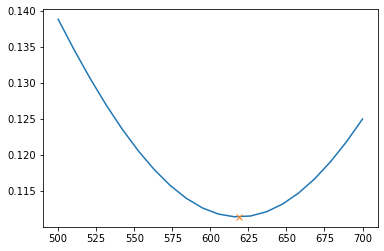

In [31]:
ml.solve()
Aopt = ml.parameters.loc['recharge_A', 'optimal']
rmseopt = ml.stats.rmse()
Alist = np.linspace(500, 700, 20)
rmse = np.zeros(len(Alist))
for i, A in enumerate(Alist):
    #ml.parameters.loc['recharge_A', 'optimal'] = A
    ml.set_parameter('reacharge_A',)
    rmse[i] = ml.stats.rmse()
    print(f'value of A: {A}, rmse: {ml.stats.rmse()}')
plt.plot(Alist, rmse)
plt.plot(Aopt, rmseopt, 'C1x')

<AxesSubplot:xlabel='date'>

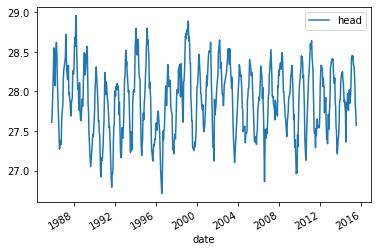

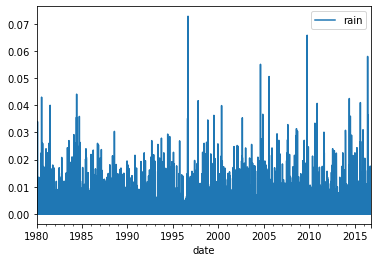

In [33]:
ho.plot()
rain.plot()

In [35]:
ml.set_parameter?

Signature:
ml.set_parameter(
    name,
    initial=None,
    vary=None,
    pmin=None,
    pmax=None,
    move_bounds=False,
)
Docstring:
Method to change the parameter properties.

Parameters
----------
name: str
    name of the parameter to update. This has to be a single variable.
initial: float, optional
    parameters value to use as initial estimate.
vary: bool, optional
    boolean to vary a parameter (True) or not (False).
pmin: float, optional
    minimum value for the parameter.
pmax: float, optional
    maximum value for the parameter.
move_bounds: bool, optional
    Reset pmin/pmax based on new initial value. Of move_bounds=True,
    pmin and pmax must be None.

Examples
--------
>>> ml.set_parameter(name="constant_d", initial=10, vary=True,
>>>                  pmin=-10, pmax=20)

Note
----
It is highly recommended to use this method to set parameter
properties. Changing the parameter properties directly in the
parameter `DataFrame` may not work as expected.
File:      ~/g

In algemene zin wordt onder kalibratie verstaan het vinden van de modelparameters zodat de uitkomst van het tijdreeksmodel zo goed mogelijk overeenkomt met de gemeten waarden. De gevonden parameters worden de optimale parameters genoemd. 

Er wordt vanuit gegaan dat er een modelstructuur gekozen is (zie Notebook Modelstructuur). Daarnaast dienen er nog een aantal andere keuzes gemaakt te worden:
1. Wanneer begint het model en worden alle data gebruikt om het model te kalibreren?
2. Wat is optimaal? De meest gebruikte methode is minimalisatie van de de som van de kwadraten van de verschillen tussen de gemeten stijghoogte en de gemodelleerde stijghoogte, ook wel de kleinste kwadraten methode genoemd.
3. Welke methode wordt gebruikt voor het vinden van de optimale parameters? Er zijn vele verschillende methodes voor het zoeken van optimale parameters met verschillende kenmerken. Het succes van de meeste methodes hangt af van de opgegeven beginwaarden van de parameters. 
4. Wordt er een ruismodel gebruikt of niet, en als er een ruismodel gebruikt wordt, welk ruismodel? Een ruismodel kan gebruikt worden om te proberen er voor te zorgen dat de overgebleven verschillen tussen het model en de metingen aan een aantal statistische toetsen voldoen zodat er statistische uitspraken gedaan kunnen worden met het model (bijvoorbeeld: wat is de kans dat het effect van een onttrekking boven een bepaalde grenswaarde uitkomt).

Het mogelijke gevolg van iedere keuze wordt toegelicht aan de hand van geslaagde en minder geslaagde voorbeeldmodellen uit de praktijk.

